In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io

# Loading and Converting Image

In [3]:
load_img_path='D:/Image/Sample.tif'
save_png_path = 'D:/png_version.png'
save_contrast_img_path = 'D:/Contrast.png'

#Convert to png
im = Image.open(load_img_path)
im.mode = 'I'
im.point(lambda i:i*(1./256)).convert('L').save(save_png_path)

#Change the Contrast
im = Image.open(save_png_path)

#image brightness enhancer
enhancer = ImageEnhance.Contrast(im)

factor = 2 #increase contrast
im_output = enhancer.enhance(factor)
im_output.save(save_contrast_img_path)

original_img = cv2.imread(save_png_path, cv2.IMREAD_GRAYSCALE)

image = cv2.imread(save_contrast_img_path, cv2.IMREAD_GRAYSCALE)

# Seperating

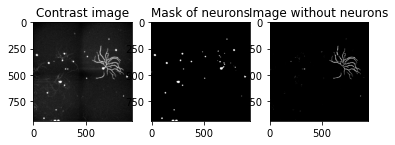

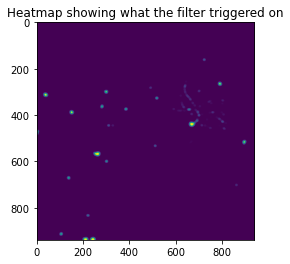

In [4]:
# Threshold the image to get a binary image morphological operators can work on
thresh, image_binary = cv2.threshold(image, 128,255, cv2.THRESH_BINARY)

# Remove really small dots by eroding them
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(7,7))
image_morph = cv2.erode(image_binary.astype(np.uint8), kernel)

# Looking for circles, so make an 11x11 circle filter
#  and filter the image by it. Where ever this output is 'high'
#  there are a lot of pixels under it that are 'high'. So this will
#  highlight circles. Note that the filter size is larger than the
#  dendrites width. This is important otherwise all dendrites will 
#  trigger the filter
k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
mask = cv2.filter2D(image_morph, cv2.CV_32FC1, k)
mask = mask/np.sum(k)
neuron_heatmap = mask.astype(np.uint8)
thresh, mask_neurons = cv2.threshold(neuron_heatmap, 30, 255, cv2.THRESH_BINARY)

mask_dendrites = image_binary - mask_neurons

# Plot out the results
plt.subplot(1,3,1)
plt.title("Contrast image")
plt.imshow(image, cmap="gray")

plt.subplot(1,3,2)
plt.title("Mask of neurons")
plt.imshow(mask_neurons, cmap="gray")
plt.subplot(1,3,3)
plt.title("Image without neurons")
plt.imshow(mask_dendrites, cmap="gray")
plt.show()

plt.title("Heatmap showing what the filter triggered on")
plt.imshow(neuron_heatmap)
plt.show()

# A Closer Look

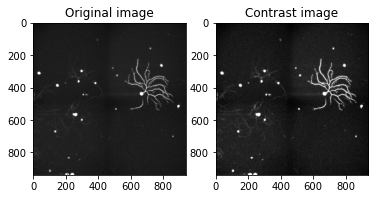

In [5]:
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(original_img, cmap="gray")
plt.subplot(1,2,2)
plt.title("Contrast image")
plt.imshow(image, cmap="gray")
plt.show()

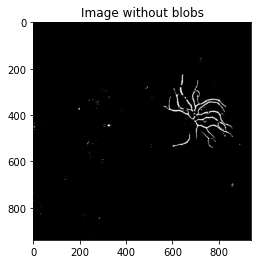

In [27]:
plt.title("Image without blobs")
plt.imshow(mask_dendrites, cmap="gray")
plt.show()

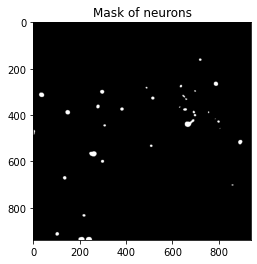

In [7]:
plt.title("Mask of neurons")
plt.imshow(mask_neurons, cmap="gray")
plt.show()

# Saving...

In [8]:
cv2.imwrite('D:/Image/mask_dendrites.png',mask_dendrites)
cv2.imwrite('D:/Image/mask_neurons.png',mask_neurons)
cv2.imwrite('D:/Image/image.png',image)


True

# Comparing SuperPixels

<ipython-input-31-1ef604c9c615>:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gradient = sobel(rgb2gray(img))


Felzenszwalb number of segments: 117
SLIC number of segments: 199
Quickshift number of segments: 2281


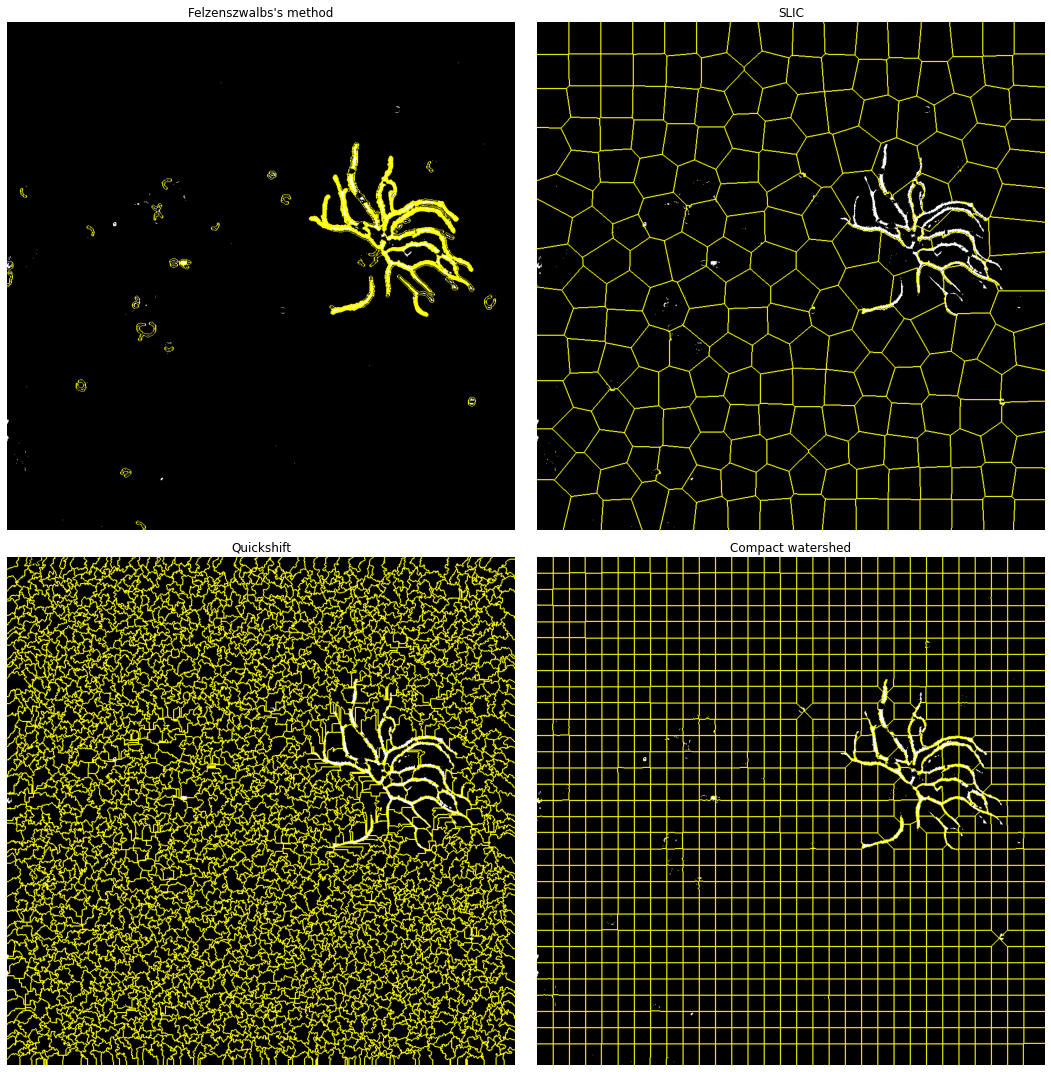

In [31]:
image = img_as_float(io.imread('D:/Image/mask_dendrites.png')).astype(np.float64)

#img = img_as_float(astronaut()[::2, ::2])

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=0.001, sigma=0.5,
                     start_label=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=100, ratio=0.5,convert2lab = False)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=1000, compactness=0.001)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')

fig, ax = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()